In [1]:
import sys; sys.path.append("/home/gonzaeve/boids/leader-follower")
import numpy as np
import matplotlib.pyplot as plt
from lib.file_helper import loadBatch
from lib.plot_helpers import plotBatchPerformance, PerformanceMetric
import matplotlib
font = {
        # 'family' : 'Helvetica',
        # 'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

In [2]:
"""Load in the batch data"""
start_trial_num = 59
num_stat_runs = 20
computername = "experiment_7a"

tested_G = True
tested_D = True
tested_Dfollow = True

num_generations, trial_datas_Dfollow, trial_datas_D, trial_datas_G = loadBatch(
    computername=computername,
    start_trial_num=start_trial_num,
    num_stat_runs=num_stat_runs,
    tested_G=tested_G,
    tested_D=tested_D,
    tested_Dfollow=tested_Dfollow
)

Dfollow trials:  ['trial_59', 'trial_58', 'trial_57', 'trial_56', 'trial_55', 'trial_54', 'trial_53', 'trial_52', 'trial_51', 'trial_50', 'trial_49', 'trial_48', 'trial_47', 'trial_46', 'trial_45', 'trial_44', 'trial_43', 'trial_42', 'trial_41', 'trial_40']
D trials:  ['trial_39', 'trial_38', 'trial_37', 'trial_36', 'trial_35', 'trial_34', 'trial_33', 'trial_32', 'trial_31', 'trial_30', 'trial_29', 'trial_28', 'trial_27', 'trial_26', 'trial_25', 'trial_24', 'trial_23', 'trial_22', 'trial_21', 'trial_20']
G trials:  ['trial_19', 'trial_18', 'trial_17', 'trial_16', 'trial_15', 'trial_14', 'trial_13', 'trial_12', 'trial_11', 'trial_10', 'trial_9', 'trial_8', 'trial_7', 'trial_6', 'trial_5', 'trial_4', 'trial_3', 'trial_2', 'trial_1', 'trial_0']


100%|██████████| 1001/1001 [00:25<00:00, 40.04it/s]


Saving plot as  figures/trial_59 | stat_runs 20 | Evaluation Team | G D Df | std err | experiment_7a.png


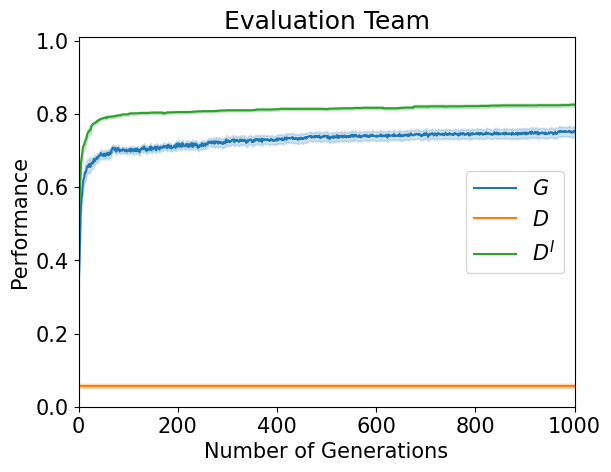

In [8]:
"""Plot the evaluation team performance metric"""
plot_min_max_range = False

plotBatchPerformance(
    trial_datas_G=trial_datas_G,
    trial_datas_D=trial_datas_D,
    trial_datas_Dfollow=trial_datas_Dfollow,
    plot_min_max_range=plot_min_max_range,
    start_trial_num=start_trial_num,
    num_stat_runs=num_stat_runs,
    computername=computername,
    performance_metric=PerformanceMetric.EvaluationTeam
)

/tmp/ipykernel_146631/2894407917.py:74: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(all_team_fitnesses), np.array(all_agent_fitnesses)


Saving plot as  figures/trial_59 | stat_runs 20 | Best Training Team | G D Df | std err | experiment_7a.png


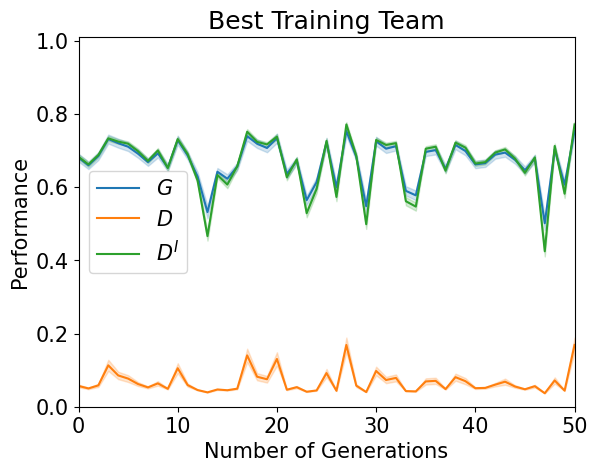

In [7]:
"""Plot the best training team performance metric"""
plot_min_max_range = False

plotBatchPerformance(
    trial_datas_G=trial_datas_G,
    trial_datas_D=trial_datas_D,
    trial_datas_Dfollow=trial_datas_Dfollow,
    plot_min_max_range=plot_min_max_range,
    start_trial_num=start_trial_num,
    num_stat_runs=num_stat_runs,
    computername=computername,
    performance_metric=PerformanceMetric.BestTrainingTeam
)

In [6]:
""" These functions are for parsing the data from loadTrialData() into more easily manageable pieces of data""" 

import numpy as np
import os
from typing import List

def getEvalFitnesses(trial_data: dict):
    # List of floating point values. Each value is a team fitness
    team_fitnesses = []
    # List of sublists of floating point values. Each sublist is the agent fitnesses at that generation
    agent_fitnesses = []

    for generation_data in trial_data:
        team_fitnesses.append(generation_data["evaluation_team"]["team_fitness"])
        agent_fitnesses.append(generation_data["evaluation_team"]["agent_fitnesses"])
    
    return np.array(team_fitnesses), np.array(agent_fitnesses)

def getAllEvalFitnesses(trial_datas: List[dict]):
    # Get all the team fitness and agent specific fitnesses for the evaluation teams
    all_team_fitnesses = []
    all_agent_fitnesses = []
    for trial_data in trial_datas:
        team_fitnesses, agent_fitnesses = getEvalFitnesses(trial_data)
        all_team_fitnesses.append(team_fitnesses)
        all_agent_fitnesses.append(agent_fitnesses)
    return np.array(all_team_fitnesses), np.array(all_agent_fitnesses)

def getEvalStatistics(trial_datas: List[dict]):
    # This assumes that all of these trials come from the same config
    # (Each trial was run with the same exact configuration)

    # Get all the team fitnesses and agent fitnesses out
    all_team_fitnesses, _ = getAllEvalFitnesses(trial_datas)

    # Get statistics accross these runs
    avg_team_fitness_arr = np.average(all_team_fitnesses, axis=0)
    std_dev_team_fitness_arr = np.std(all_team_fitnesses, axis=0)
    upper_err_team_fitness_arr = avg_team_fitness_arr + std_dev_team_fitness_arr/np.sqrt(all_team_fitnesses.shape[0])
    lower_err_team_fitness_arr = avg_team_fitness_arr - std_dev_team_fitness_arr/np.sqrt(all_team_fitnesses.shape[0])
    upper_range = np.max(all_team_fitnesses, axis=0)
    lower_range = np.min(all_team_fitnesses, axis=0)

    return avg_team_fitness_arr, std_dev_team_fitness_arr, upper_err_team_fitness_arr, lower_err_team_fitness_arr, upper_range, lower_range

def getBestFitnesses(trial_data: dict):
    # List of floating point values. Each value is a team fitness
    team_fitnesses = []
    # List of sublists of floating point values. Each sublist is the agent fitnesses at that generation
    # We use the highest score of an agent across its entire population. We dont' make this dependent on whether this particular
    # policy was used in the random team that got the best team fitness
    agent_fitnesses = []

    for generation_data in trial_data:
        team_fitnesses = [generation_data["training_teams"][team_name]["team_fitness"] for team_name in generation_data["training_teams"].keys()]
        best_team_fitness = max(team_fitnesses)

        agent_fitnesses = [generation_data["training_teams"][team_name]["agent_fitnesses"] for team_name in generation_data["training_teams"].keys()]
        best_agent_fitnesses = [max(agent_fitness_list) for agent_fitness_list in agent_fitnesses]

        team_fitnesses.append(best_team_fitness)
        agent_fitnesses.append(best_agent_fitnesses)

    return team_fitnesses, agent_fitnesses

def getAllBestFitnesses(trial_datas: List[dict]):
    # Get all the team fitness and agent specific best fitnesses for the training teams
    all_team_fitnesses = []
    all_agent_fitnesses = []
    for trial_data in trial_datas:
        team_fitnesses, agent_fitnesses = getBestFitnesses(trial_data)
        all_team_fitnesses.append(team_fitnesses)
        all_agent_fitnesses.append(agent_fitnesses)
    return np.array(all_team_fitnesses), np.array(all_agent_fitnesses)

def getBestStatistics(trial_datas: List[dict]):
    # This assumes that all of these trials come from the same config
    # (Each trial was run with the same exact configuration)

    # Get all the team fitnesses out
    all_team_fitnesses, _ = getAllBestFitnesses(trial_datas)

    # Get statistics accross these runs
    avg_team_fitness_arr = np.average(all_team_fitnesses, axis=0)
    std_dev_team_fitness_arr = np.std(all_team_fitnesses, axis=0)
    upper_err_team_fitness_arr = avg_team_fitness_arr + std_dev_team_fitness_arr/np.sqrt(all_team_fitnesses.shape[0])
    lower_err_team_fitness_arr = avg_team_fitness_arr - std_dev_team_fitness_arr/np.sqrt(all_team_fitnesses.shape[0])
    upper_range = np.max(all_team_fitnesses, axis=0)
    lower_range = np.min(all_team_fitnesses, axis=0)

    return avg_team_fitness_arr, std_dev_team_fitness_arr, upper_err_team_fitness_arr, lower_err_team_fitness_arr, upper_range, lower_range

def getTrialNames(trial_num: int, num_stat_runs: int):
    trialnames = []
    for i in range(num_stat_runs):
        trialnames.append("trial_"+str(trial_num))
        trial_num -= 1
    return trialnames, trial_num

import numpy as np
from typing import Optional
from enum import IntEnum

class PerformanceMetric(IntEnum):
    BestTrainingTeam = 0
    EvaluationTeam = 1

def plotStatisticsAvg(avg, color):
    num_generations_arr = np.arange(avg.shape[0])
    plt.plot(num_generations_arr, avg, color=color)

def plotStatisticsRange(upper_dev, lower_dev, upper_range, lower_range, color, plot_min_max_range=False):
    num_generations_arr = np.arange(upper_dev.shape[0])
    plt.fill_between(num_generations_arr, upper_dev.flatten(), lower_dev.flatten(), alpha=0.2, color=color)
    if plot_min_max_range:
        plt.fill_between(num_generations_arr, upper_range.flatten(), lower_range.flatten(), alpha=0.2, color=color)

def plotBatchPerformance(trial_datas_G: Optional[dict], trial_datas_D: Optional[dict], trial_datas_Dfollow: Optional[dict], \
                        plot_min_max_range: bool, start_trial_num: int, num_stat_runs: int, computername: str, performance_metric: PerformanceMetric):
    plt.figure(0)

    if performance_metric.value == PerformanceMetric.BestTrainingTeam.value:
        getStatistics = getBestStatistics
        title = "Best Training Team"
    elif performance_metric.value == PerformanceMetric.EvaluationTeam.value:
        getStatistics = getEvalStatistics
        title = "Evaluation Team"

    # Get statistics for different reward structures
    # We plot the baselines first so that D-Indirect is on the top layer
    legend = []
    if trial_datas_G is not None:
        avg_G, std_dev_G, upper_err_G, lower_err_G, upper_G, lower_G = getStatistics(trial_datas_G)
        plotStatisticsAvg(avg_G, color='tab:blue')
        legend.append("$G$")
        num_generations_arr = np.arange(avg_G.shape[0])

    if trial_datas_D is not None:
        avg_D, std_dev_D, upper_err_D, lower_err_D, upper_D, lower_D = getStatistics(trial_datas_D)
        plotStatisticsAvg(avg_D, color='tab:orange')
        legend.append("$D$")
        num_generations_arr = np.arange(avg_D.shape[0])

    if trial_datas_Dfollow is not None:
        avg_Df, std_dev_Df, upper_err_Df, lower_err_Df, upper_Df, lower_Df = getStatistics(trial_datas_Dfollow)
        plotStatisticsAvg(avg_Df, color='tab:green')
        legend.append(r'$D^I$')
        num_generations_arr = np.arange(avg_Df.shape[0])

    # Automatically figure out how many generations were in here
    plt.ylim([0,1.01])
    plt.xlim([0,len(num_generations_arr)-1])

    # Add the standard error or min max plotting
    if trial_datas_G is not None: 
        plotStatisticsRange(upper_err_G, lower_err_G, upper_G, lower_G, 'tab:blue', plot_min_max_range)
    if trial_datas_D is not None:
        plotStatisticsRange(upper_err_D, lower_err_D, upper_D, lower_D, 'tab:orange', plot_min_max_range)
    if trial_datas_Dfollow is not None:
        plotStatisticsRange(upper_err_Df, lower_err_Df, upper_Df, lower_Df, 'tab:green', plot_min_max_range)

    plt.legend(legend)

    # plt.legend(["$G$", "$D$", r'$D_{follow}$'])

    plt.xlabel("Number of Generations")
    plt.ylabel("Performance")
    plt.title(title)

    # plt.xlim([0,150])

    plot_save_name = "figures/trial_"+str(start_trial_num)+" | stat_runs "+str(num_stat_runs)+" | "+title+" |"
    if trial_datas_G:
        plot_save_name += " G"
    if trial_datas_D:
        plot_save_name += " D"
    if trial_datas_Dfollow:
        plot_save_name += " Df"
    if plot_min_max_range:
        plot_save_name += " | full range"
    else:
        plot_save_name += " | std err"
    plot_save_name += " | " + computername
    plot_save_name += ".png"

    print("Saving plot as ", plot_save_name)
    plt.savefig(plot_save_name)

    plt.show()

